In [65]:
companies = [
    "SAP", "IBM", "WDAY", "ADP", "ACN",  # Technology
    "NXPI", "STM", "ADI", "ON", "MCHP", "LSCC", "COHR", "AEIS", "ENTG",  # Semiconductors & Software
    "BX", "KKR", "STT", "AMP", "PNC", "CFG", "BK", "NTRS", "FITB",  # Financials
    "UL", "PDD", "JD", "BABA", "SBUX", "YUM", "ROST", "M", "KSS",  # Consumer Discretionary & Retail
    "ZTS", "DHR", "BDX", "SYK", "BSX", "STE", "MTD", "BIO",  # Healthcare
    "TAP", "KMB", "GIS", "HRL", "MDLZ", "LW", "MNST",  # Consumer Staples
]


In [79]:
companies = [
    "OKTA", "DOCU", "CDNS", "ANSS", "TTD",  # Technology
    "ICE", "AJG", "PGR", "CINF", "ALL",     # Financials
    "HES", "MPC", "CLR", "FTI", "WMB",      # Energy
    "ES", "XEL", "WEC", "PEG", "DTE",       # Utilities
    "LVS", "MGM", "HOG", "BBBY", "DHI",     # Consumer Discretionary
    "UPS", "FDX", "ROK", "ETN", "SWK"       # Industrials
]


In [89]:
companies = ['RACE']

In [1]:
import yfinance as yf
import pandas as pd
import pandas_ta as ta
import matplotlib.pyplot as plt
import numpy as np
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.metrics import mean_squared_error, accuracy_score
import seaborn as sns
from tensorflow import keras
import tensorflow as tf
from tensorflow.keras import layers
import xgboost as xgb
from sklearn.metrics import r2_score
from sklearn.model_selection import KFold

In [2]:
companies = ['JCI', 'HAL', 'DHR', 'RTX', 'HDB', 'V', 'DECK', 'SNDK', 'SQ', 'AXP', 'SLB', 'GS', 'BABA', 'AIG', 'CSCO', 'MCD', 'CRBP', 
            'OXY', 'TRV', 'CRWD', 'ADI', 'NOC', 'NOW', 'CAT', 'SPY', 'TPR', 'T', 'NKE', 'SNAP', 'RHT', 'CMI', 'GIII', 'SYK', 
            'BLK', 'STT', 'DDOG', 'UBER', 'COP', 'DBX', 'NET', 'AMZN', 'DIS', 'LRCX', 'MU', 'FIVN', 'NTES', 'ANF', 'TTD', 'ITW',
            'BDX', 'SYF', 'CRIS', 'GE', 'PFE', 'DOV', 'ETFC', 'LMT', 'WMT', 'HSBC', 'VFC', 'LOW', 'NXPI', 'NFLX', 'TD', 'BILL', 'SCHW', 'ARO', 'MS', 'ABT', 'TSLA',
                'DE', 'SPGI', 'COF', 'MRNA', 'PGR', 'ESTC', 'TWLO', 'RY', 'VEEV', 'LYFT', 'VLO', 'BA', 'PLCE', 'WFC', 'OKTA', 'VEON', 'NYT', 'INTC', 'HBI', 'AVGO', 'PLAN', 
                'BMY', 'JNPR', 'QCOM', 'CHK', 'MELI', 'RDS-A', 'GILD', 'IDXX', 'MDT', 'ADDYY', 'ENB', 'HES', 'UNM', 'BAX', 'KO', 'REGN', 'SWKS', 'CME', 'ZM', 'PYPL', 'HUBS', 
                'STX', 'BP', 'HON', 'PRU', 'VRTX', 'EMR', 'ISRG', 'CTLT', 'P&G', 
            'FISV', 'XOM', 'MA', 'ORCL', 'PBR', 'MRK', 'BAC', 'TMO', 'GOOGL', 'CROX', 'HD', 'WIX', 'STZ',
            'AMT', 'BIDU', 'WDC', 'RL', 'C', 'MRO', 'SPOT', 'MO', 'SI', 'RTN', 'MET', 'JNJ', 'CIG', 'AMGN', 'ZS', 'TDG', 'TGT', 'ON', 'ALL', 'VZ', 'LULU',
            'TXN', 'DOCU', 'AMAT', 'MSFT', 'FB', 'RBLX', 'LNC', 'JPM', 'SHOP', 'AMTD', 'MPC', 'IBM', 'NVDA', 'MMM', 'USB', 'GD', 'UAA', 
            'DKS', 'IQV', 'KMI', 'TLT', 'XPEV', 'FTNT', 'CVX', 'UNH', 'PEP', 'BNS', 'TSM', 'AAPL', 'TWTR', 'MERR']


In [3]:
def remove_outliers(data, column):
    Q1 = data[column].quantile(0.25)
    Q3 = data[column].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    return data[(data[column] >= lower_bound) & (data[column] <= upper_bound)].reset_index(drop=True)

In [4]:
def scale_data(uncscaled_data):
    price_columns = ['Open', 'High', 'Low', 'Close']
    technical_indicators = ['SMA15', 'EMA5', 'RSI15', 'BB_upper', 'BB_lower',
                            'MACD', 'MACD_signal', 'OBV', 'ADX', 'Aroon_Up', 'Aroon_Down']
    volume_column = 'Volume'

    for col in price_columns:
        uncscaled_data = remove_outliers(uncscaled_data, col)

    # Standardize price columns
    standard_scaler = StandardScaler()
    uncscaled_data[price_columns] = standard_scaler.fit_transform(uncscaled_data[price_columns])

    # Apply log transformation and standard scaling for volume
    uncscaled_data[volume_column] = np.log1p(uncscaled_data[volume_column])
    uncscaled_data[[volume_column]] = standard_scaler.fit_transform(uncscaled_data[[volume_column]])

    # Standardize technical indicators
    uncscaled_data[technical_indicators] = standard_scaler.fit_transform(uncscaled_data[technical_indicators])

    return uncscaled_data


In [5]:
def calculate_tech_ind(curr, data):
    # Add technical indicators
    data['SMA15'] = ta.sma(curr['Close'], length=15)
    data['EMA5'] = ta.ema(curr['Close'], length=5)
    data['RSI15'] = ta.rsi(curr['Close'], length=15)

    # Bollinger Bands
    data['BB_upper'], data['BB_lower'] = ta.bbands(curr['Close'], length=56, std=2).iloc[:, [0, 2]].T.values

    # MACD and Signal Line
    data['MACD'], data['MACD_signal'] = ta.macd(curr['Close']).iloc[:, [0, 1]].T.values

    # On-Balance Volume
    data['OBV'] = ta.obv(curr['Close'], curr['Volume'])

    # ADX
    data['ADX'] = ta.adx(curr['High'], curr['Low'], curr['Close']).iloc[:, 0]

    # Aroon Oscillator
    data['Aroon_Up'], data['Aroon_Down'] = ta.aroon(curr['High'], curr['Low']).iloc[:, [0, 1]].T.values

    # Combine curr and indicators
    combined_data = pd.concat([curr, data], axis=1)

    # Drop rows with NaN values
    combined_data.dropna(inplace=True)

    # Scale data
    scaled_data = scale_data(combined_data)

    return scaled_data, combined_data.index


In [6]:
from joblib import load

loaded_model = load('model_reg.joblib')

In [7]:
prediction = pd.DataFrame(columns=['symbol', 'actual', 'predicted', 'date'])

In [ ]:
import pandas as pd
import yfinance as yf
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, r2_score
import numpy as np
import matplotlib.pyplot as plt

# Assuming prediction DataFrame is already created
prediction = pd.DataFrame(columns=['symbol', 'actual', 'predicted', 'date'])

average = []
for i in companies:
    try:
        # Download stock data
        curr = yf.download(i, start='2024-01-11', end='2024-11-23')
        curr = curr.reset_index()
        curr.columns = [col[0] for col in curr.columns]
        date = curr['Date']
        target_act = curr['Close']
        curr.drop(columns=['Date'], inplace=True)
        empty_data = pd.DataFrame()

        # Calculate technical indicators and align data
        result_df, valid_indices = calculate_tech_ind(curr, empty_data)

        # Align dates and target with valid rows
        aligned_dates = date.iloc[valid_indices].reset_index(drop=True)
        aligned_target = target_act.iloc[valid_indices].reset_index(drop=True)

        # Scale target for modeling
        standard_scaler_close = StandardScaler()
        target_scaled = standard_scaler_close.fit_transform(aligned_target.values.reshape(-1, 1))

        # Prepare input data for the model
        input_data = result_df.drop(columns=['Low', 'Open', 'SMA15', 'BB_lower', 'BB_upper', 
                                             'Adj Close', 'Close', 'OBV'])

        # Predict using the loaded model
        y_pred = loaded_model.predict(input_data)

        # Reshape predictions and target
        y_pred_reshaped = pd.DataFrame(y_pred, columns=["Close"]).values.reshape(-1, 1)
        target_reshaped = pd.DataFrame(target_scaled, columns=["Close"]).values.reshape(-1, 1)

        # Evaluate model performance
        mse = mean_squared_error(target_reshaped, y_pred_reshaped)
        rmse = np.sqrt(mse)
        target_actual = target_scaled.reshape(-1)
        target_predicted = y_pred.reshape(-1)

        # Calculate R^2 using sklearn
        r2 = r2_score(target_actual, target_predicted)
        print(f'\nCompany: {i}\nMean Squared Error: {mse}\nRoot Mean Squared Error: {rmse}\nR-squared: {r2}')

        # Perform inverse transformation
        y_pred_original = standard_scaler_close.inverse_transform(y_pred_reshaped)
        target_original = standard_scaler_close.inverse_transform(target_reshaped)

        # Plot the actual vs predicted prices
        plt.figure(figsize=(30, 16))
        plt.plot(aligned_dates, target_original, label="Actual Price", color="blue")
        plt.plot(aligned_dates, y_pred_original, label="Predicted Price", color="orange")
        plt.title("Actual vs Predicted Close Price")
        plt.xlabel("Date")
        plt.ylabel("Close Price")
        plt.xticks(rotation=45)
        plt.legend()
        plt.grid(True)
        plt.show()

        average.append(r2)

        # Append the last 20 values to the prediction DataFrame for this company
        # Make sure to append only the last 20 records to avoid adding too many
        last_20_dates = aligned_dates[-20:]
        last_20_actual = target_original[-20:]
        last_20_predicted = y_pred_original[-20:]
        
        temp_df = pd.DataFrame({
            'symbol': [i] * 20,
            'actual': last_20_actual.flatten(),
            'predicted': last_20_predicted.flatten(),
            'date': last_20_dates
        })
        
        prediction = pd.concat([prediction, temp_df], ignore_index=True)

    except Exception as e:
        print(f'Error for {i}: {e}')


In [9]:
prediction

,symbol,actual,predicted,date
0,JCI,77.730003,77.452576,2024-10-28 00:00:00+00:00
1,JCI,77.070000,76.685646,2024-10-29 00:00:00+00:00
2,JCI,76.320000,76.144150,2024-10-30 00:00:00+00:00
3,JCI,75.550003,75.851669,2024-10-31 00:00:00+00:00
4,JCI,75.500000,75.109116,2024-11-01 00:00:00+00:00
...,...,...,...,...
2215,MERR,0.000100,0.001779,2024-11-18 00:00:00+00:00
2216,MERR,0.000100,0.001779,2024-11-19 00:00:00+00:00
2217,MERR,0.000100,0.001779,2024-11-20 00:00:00+00:00
2218,MERR,0.000100,0.001779,2024-11-21 00:00:00+00:00


In [10]:
prediction.to_csv('predicted_new.csv')

Trial 1: 0.9406540715103998 0.9927281557129863 0.9731379277467157

Trial 2: 0.9548101710880643 0.9887290605166047 0.9746071098678473

In [ ]:
average = []
for i in companies:
    try:
        curr = yf.download(i, start='2024-01-11', end='2024-11-23')
        curr = curr.reset_index()
        curr.columns = [col[0] for col in curr.columns]
        date = curr['Date']
        target_act = curr['Close']
        curr.drop(columns=['Date'], inplace=True)
        empty_data = pd.DataFrame()

        # Calculate indicators and align data
        result_df, valid_indices = calculate_tech_ind(curr, empty_data)

        # Align dates and target with valid rows
        aligned_dates = date.iloc[valid_indices].reset_index(drop=True)
        aligned_target = target_act.iloc[valid_indices].reset_index(drop=True)

        # Scale target for modeling
        standard_scaler_close = StandardScaler()
        target_scaled = standard_scaler_close.fit_transform(aligned_target.values.reshape(-1, 1))

        # Prepare input data
        input_data = result_df.drop(columns=['Low', 'Open', 'SMA15', 'BB_lower', 'BB_upper',
                                             'Adj Close', 'Close', 'OBV'])

        # Predict using the loaded model
        y_pred = loaded_model.predict(input_data)

        # Reshape predictions and target
        y_pred_reshaped = pd.DataFrame(y_pred, columns=["Close"]).values.reshape(-1, 1)
        target_reshaped = pd.DataFrame(target_scaled, columns=["Close"]).values.reshape(-1, 1)

        # Evaluate model performance
        mse = mean_squared_error(target_reshaped, y_pred_reshaped)
        rmse = np.sqrt(mse)
        target_actual = target_scaled.reshape(-1)
        target_predicted = y_pred.reshape(-1)

        # Calculate R^2 using sklearn
        r2 = r2_score(target_actual, target_predicted)
        print(f'\nCompany: {i}\nMean Squared Error: {mse}\nRoot Mean Squared Error: {rmse}\nR-squared: {r2}')

        # Perform inverse transformation
        y_pred_original = standard_scaler_close.inverse_transform(y_pred_reshaped)
        target_original = standard_scaler_close.inverse_transform(target_reshaped)

        # Plot the actual vs predicted prices
        plt.figure(figsize=(30, 16))
        plt.plot(aligned_dates, target_original, label="Actual Price", color="blue")
        plt.plot(aligned_dates, y_pred_original, label="Predicted Price", color="orange")
        plt.title("Actual vs Predicted Close Price")
        plt.xlabel("Date")
        plt.ylabel("Close Price")
        plt.xticks(rotation=45)
        plt.legend()
        plt.grid(True)
        plt.show()
        average.append(r2)
    except Exception as e:
        print(f'Error for {i}: {e}')


In [26]:
prediction.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2220 entries, 0 to 2219
Data columns (total 4 columns):
 #   Column     Non-Null Count  Dtype              
---  ------     --------------  -----              
 0   symbol     2220 non-null   object             
 1   actual     2220 non-null   float64            
 2   predicted  2220 non-null   float32            
 3   date       2220 non-null   datetime64[ns, UTC]
dtypes: datetime64[ns, UTC](1), float32(1), float64(1), object(1)
memory usage: 60.8+ KB


In [15]:
def final_pcas(data):
    feature_columns = ['Open', 'High', 'Low', 'SMA15', 'EMA5',
            'RSI15', 'BB_upper', 'BB_lower', 'OBV', 'ADX',
            'Aroon_Up', 'Aroon_Down']

    X = data[feature_columns]
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X)

    pca = PCA(n_components=8)  
    X_pca = pca.fit_transform(X_scaled)

    explained_variance = pca.explained_variance_ratio_
    cumulative_variance = np.cumsum(explained_variance)


    n_components_to_keep = np.argmax(cumulative_variance >= 0.90) 
    pca_final = PCA(n_components=n_components_to_keep)
    X_final = pca_final.fit_transform(X_scaled)

    pca_columns = [f'PC{i+1}' for i in range(n_components_to_keep)]
    pca_df = pd.DataFrame(data=X_final, columns=pca_columns)
    data = pd.DataFrame(data=data, columns=['MACD', 'MACD_signal', 'Close'])
    result_df = pd.concat([data.reset_index(drop=True), pca_df.reset_index(drop=True)], axis=1)

    return result_df


In [16]:
target = scaled_data[['Close']]  # Ensures 2D shape
standard_scaler_close = StandardScaler()
target_scaled = standard_scaler_close.fit_transform(target)

In [17]:
target_scaled

array([[-3.54472161],
       [-3.40052823],
       [-3.51285686],
       [-2.11180277],
       [-2.44009979],
       [-2.68439098],
       [-2.46327371],
       [-2.38248667],
       [-2.25020292],
       [-2.01170496],
       [-2.18261224],
       [-2.51766803],
       [-2.33710438],
       [-2.12306805],
       [-2.11888372],
       [-2.07961683],
       [-1.69917972],
       [-1.39083783],
       [-1.25501311],
       [-1.1500876 ],
       [-1.08635908],
       [-0.85301098],
       [-0.97499599],
       [-0.95632759],
       [-1.33547797],
       [-1.40339082],
       [-1.23698906],
       [-1.07219718],
       [-1.1047053 ],
       [-1.35382419],
       [-0.99977881],
       [-1.04966663],
       [-1.11629177],
       [-0.98239812],
       [-0.91834841],
       [-0.69851885],
       [-0.67341287],
       [-0.77093722],
       [-0.70077112],
       [-0.49800006],
       [-0.55014114],
       [-0.51183978],
       [-0.61547856],
       [-0.75033774],
       [-1.14171894],
       [-1

In [18]:

input = scaled_data.drop(columns=['Low', 'Open','SMA15', 'BB_lower', 'BB_upper', 'Adj Close', 'Close', 'OBV'])

In [19]:
#input['H-L'] = input['High'] - input['Low']

In [20]:
from joblib import load

loaded_model = load('model_reg.joblib')

In [21]:
target

,Close
18,344.929993
19,349.410004
20,345.920013
21,389.450012
22,379.250000
...,...
207,476.760010
208,476.760010
209,476.760010
210,476.760010


In [22]:
target_scaled

array([[-3.54472161],
       [-3.40052823],
       [-3.51285686],
       [-2.11180277],
       [-2.44009979],
       [-2.68439098],
       [-2.46327371],
       [-2.38248667],
       [-2.25020292],
       [-2.01170496],
       [-2.18261224],
       [-2.51766803],
       [-2.33710438],
       [-2.12306805],
       [-2.11888372],
       [-2.07961683],
       [-1.69917972],
       [-1.39083783],
       [-1.25501311],
       [-1.1500876 ],
       [-1.08635908],
       [-0.85301098],
       [-0.97499599],
       [-0.95632759],
       [-1.33547797],
       [-1.40339082],
       [-1.23698906],
       [-1.07219718],
       [-1.1047053 ],
       [-1.35382419],
       [-0.99977881],
       [-1.04966663],
       [-1.11629177],
       [-0.98239812],
       [-0.91834841],
       [-0.69851885],
       [-0.67341287],
       [-0.77093722],
       [-0.70077112],
       [-0.49800006],
       [-0.55014114],
       [-0.51183978],
       [-0.61547856],
       [-0.75033774],
       [-1.14171894],
       [-1

In [23]:
y_pred = loaded_model.predict(input)

# Evaluate the model performance
mse = mean_squared_error(target_scaled, y_pred)
print(f'Mean Squared Error: {mse}')

rmse = np.sqrt(mse)
print(f'Root Mean Squared Error (RMSE): {rmse}')

# Optional: Calculate R-squared
r2 = loaded_model.score(input, target_scaled)
print(f'R-squared: {r2}')

print('\n ', y_pred, '\n', target_scaled)

Mean Squared Error: 0.018495854957630793
Root Mean Squared Error (RMSE): 0.13599946675495017
R-squared: 0.9815041450423692

  [-2.2032757  -2.1954792  -2.1954792  -2.209654   -2.209654   -2.2066128
 -2.2111175  -2.211152   -2.2038085  -2.2038085  -2.2038085  -2.2033138
 -2.2367177  -2.2348807  -2.2038085  -2.2038085  -1.8559512  -1.4458197
 -1.2934594  -1.2296323  -1.0825769  -0.8937128  -0.98333454 -1.0193983
 -1.3656032  -1.411449   -1.3052791  -1.1844667  -1.0179286  -1.2765303
 -1.0658867  -1.0758193  -1.0873362  -1.0954498  -0.9213228  -0.80160314
 -0.76017207 -0.80716395 -0.7665498  -0.59589964 -0.5641421  -0.5650364
 -0.6853683  -0.73479915 -1.025767   -1.1872232  -1.1209432  -1.1945534
 -1.0480331  -1.126034   -1.1568234  -1.1844667  -1.411449   -1.2223698
 -1.437087   -1.2363775  -1.2940006  -1.3283412  -1.5172579  -1.0480331
 -1.0747899  -1.3767436  -1.1364409  -1.1541773  -1.2364241  -1.1844667
 -1.0751797  -0.79896617 -0.9569209  -1.210622   -1.5844048  -1.6337534
 -1.71442

In [24]:
len(y_pred)

406

Mean Squared Error: 0.00026662786562003173
Root Mean Squared Error (RMSE): 0.016328743540763684
Mean Squared Error: 0.0002666256388325786
Root Mean Squared Error (RMSE): 0.01632867535449764
R-squared: 0.0


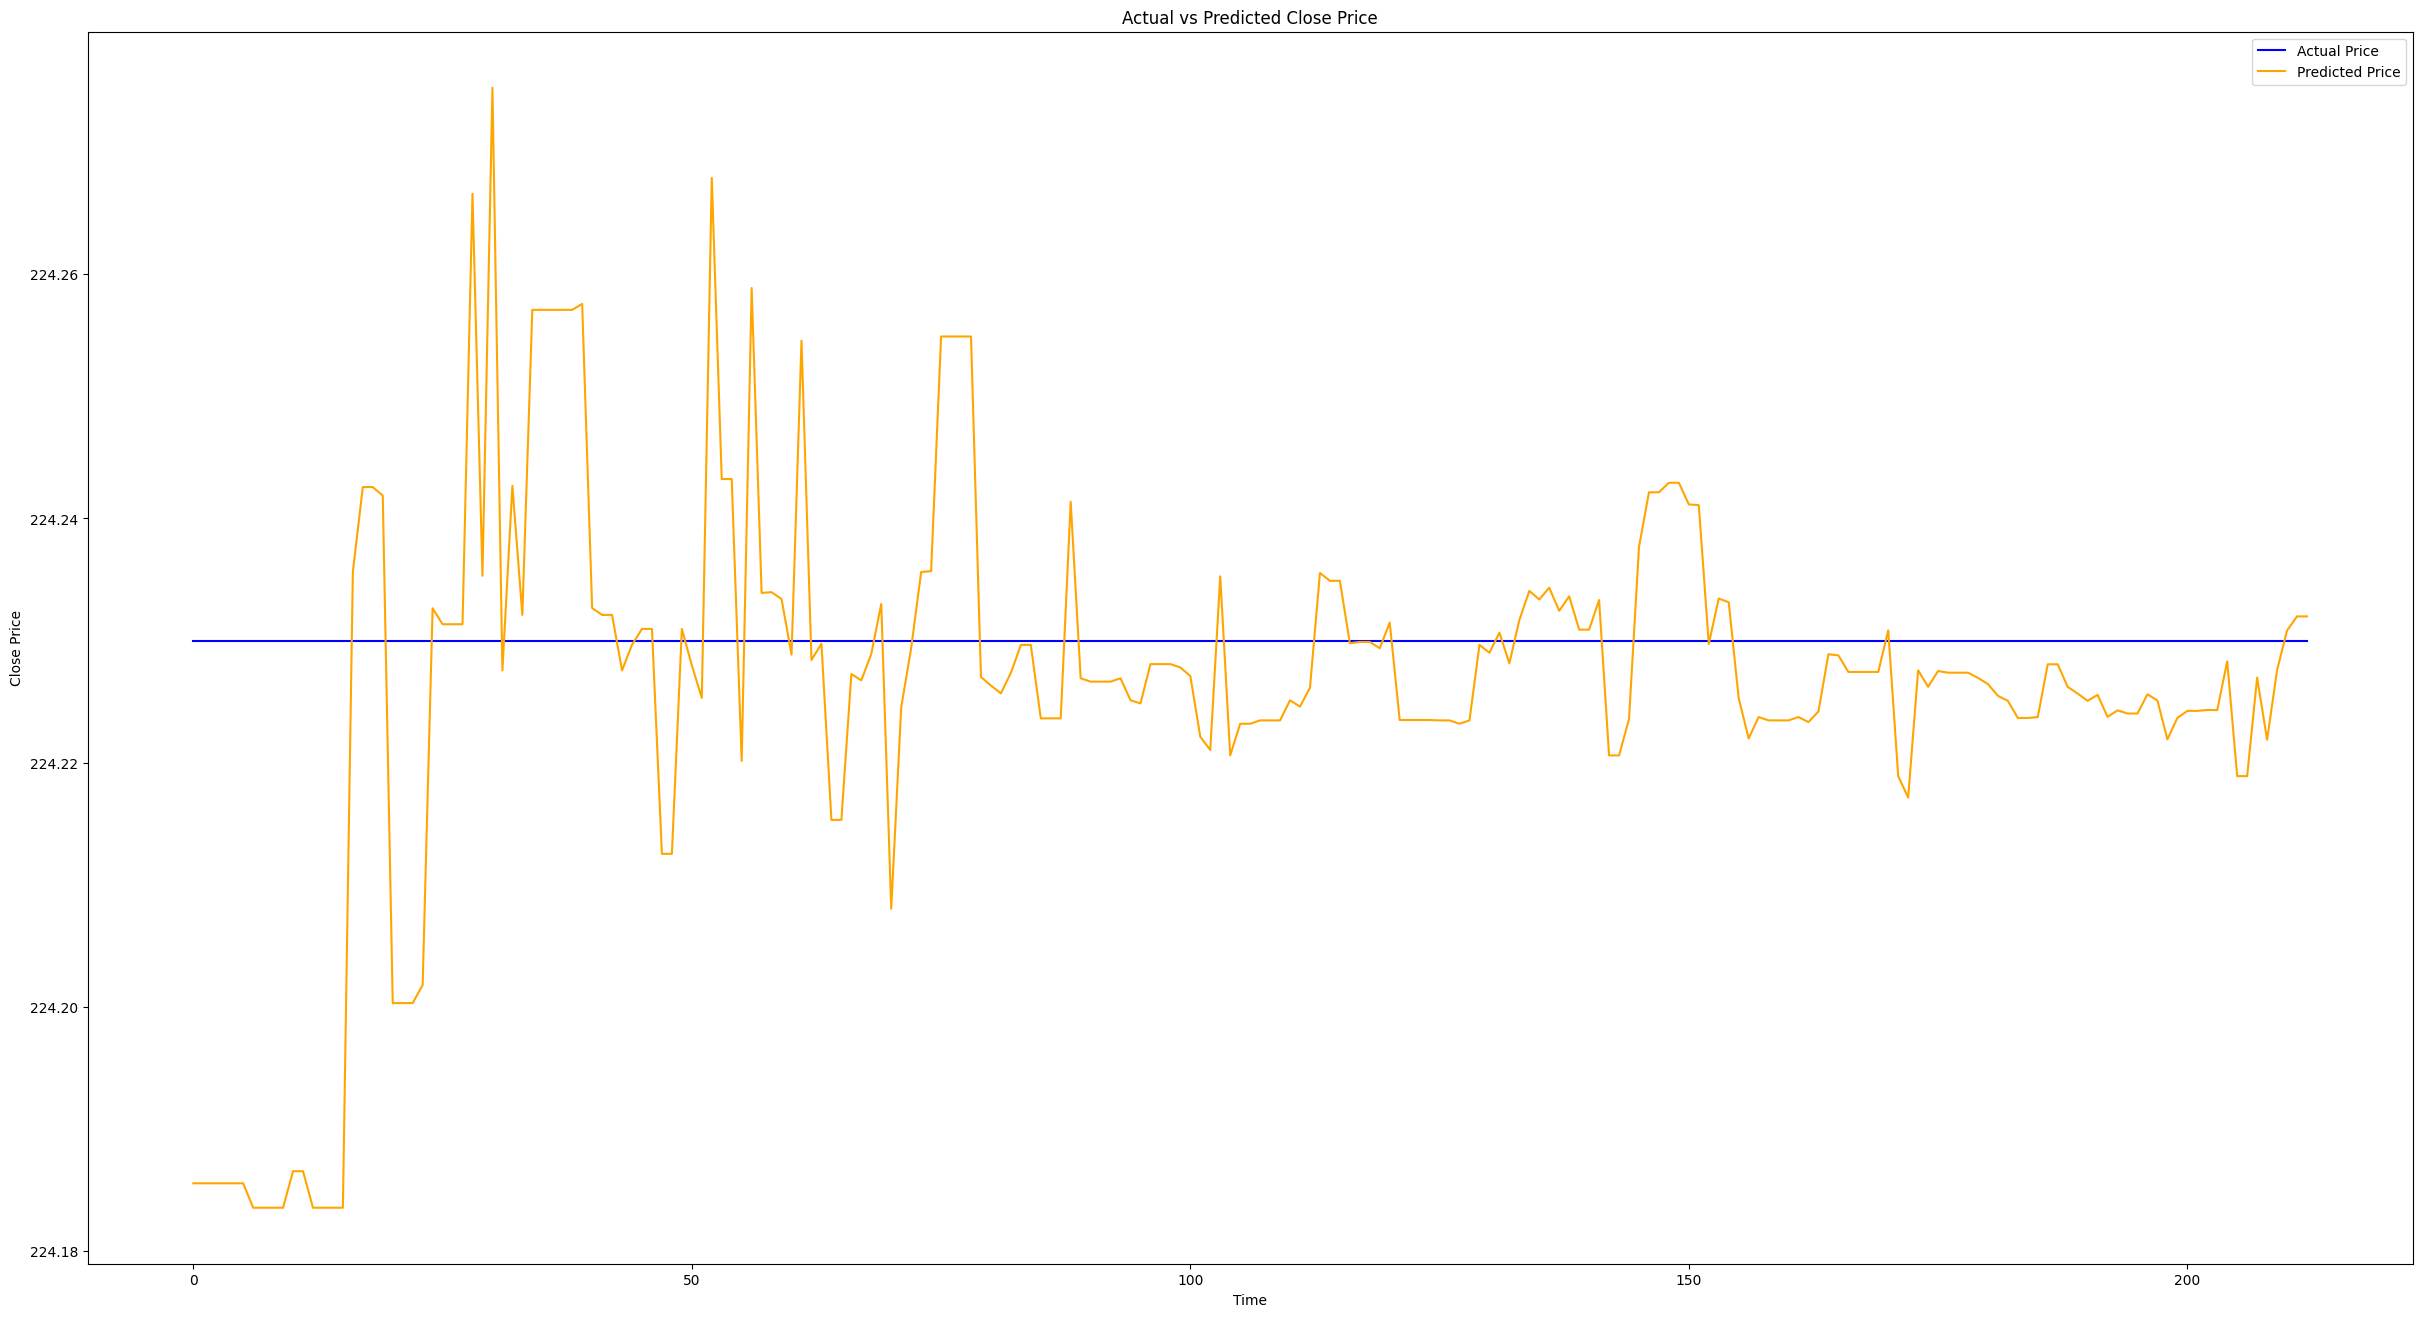

In [12]:
# Ensure y_pred and target are single-column DataFrames before reshaping
y_pred_reshaped = pd.DataFrame(y_pred, columns=["Close"]).values.reshape(-1, 1)
target_reshaped = pd.DataFrame(target_scaled, columns=["Close"]).values.reshape(-1, 1)

mse = mean_squared_error(target_reshaped, y_pred_reshaped)
print(f'Mean Squared Error: {mse}')

rmse = np.sqrt(mse)
print(f'Root Mean Squared Error (RMSE): {rmse}')

# Perform inverse transformation
y_pred_original = standard_scaler_close.inverse_transform(y_pred_reshaped)
target_original = standard_scaler_close.inverse_transform(target_reshaped)

# Plot the original vs. predicted values
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error
import numpy as np

mse = mean_squared_error(target_original, y_pred_original)
rmse = np.sqrt(mse)
print(f'Mean Squared Error: {mse}')
print(f'Root Mean Squared Error (RMSE): {rmse}')
print(f'R-squared: {r2}')

plt.figure(figsize=(30, 16))
plt.plot(target_original, label="Actual Price", color="blue")
plt.plot(y_pred_original, label="Predicted Price", color="orange")
plt.title("Actual vs Predicted Close Price")
plt.xlabel("Time")
plt.ylabel("Close Price")
plt.legend()
plt.show()


In [8]:
input

,High,Volume,EMA5,RSI15,MACD,MACD_signal,ADX,Aroon_Up,Aroon_Down
211,0.0,-3.552714e-15,-0.743616,-0.691349,-0.900536,-0.094811,0.536515,-0.612516,0.181826
0,0.0,-3.552714e-15,-0.743616,-0.691349,-0.900536,-0.094811,0.536515,-0.612516,0.181826
1,0.0,-3.552714e-15,-0.743616,-0.691349,-0.900536,-0.094811,0.536515,-0.612516,0.181826
2,0.0,-3.552714e-15,-0.743616,-0.691349,-0.900536,-0.094811,0.536515,-0.612516,0.181826
3,0.0,-3.552714e-15,-0.743616,-0.691349,-0.900536,-0.094811,0.536515,-0.612516,0.181826
...,...,...,...,...,...,...,...,...,...
207,0.0,-3.552714e-15,0.985059,-0.956401,-0.578368,-1.672526,-0.998615,1.191159,-1.028453
208,0.0,-3.552714e-15,1.033269,-0.260272,-0.544905,-1.240033,-1.067081,0.990751,-1.230167
209,0.0,-3.552714e-15,1.057714,-0.327465,-0.527894,-0.945124,-1.148568,0.790343,-1.431880
210,0.0,-3.552714e-15,1.033604,-0.667969,-0.575392,-0.909502,-1.127908,0.589934,-1.431880


In [15]:
tomorrow_close_pred = y_pred_original[-1]  # Take the last predicted value
print(f"Predicted Close Price for Tomorrow: {tomorrow_close_pred[0]:.2f}")

Predicted Close Price for Tomorrow: 319.42
